# Titanic dataset

**Goal:** <mark>Predict the likelihood for people to survive the sinking of the Titanic.</mark>

- the data can be downloaded [here](https://www.kaggle.com/competitions/titanic/data)
- place both **test.csv** and **train.csv** in the **data/** directory


In [1]:
# Load the datasets
import pathlib as p
import pandas as pd

def read_data(filename):
    rel_path = p.Path().parent.joinpath('data').joinpath(filename)
    assert rel_path.exists(), f"{rel_path} missing. Have you downloaded the data?"
    return pd.read_csv(rel_path)

train_data = read_data('train.csv')
test_data = read_data('test.csv')

# Discover and Visualize to gain insights

In [2]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- **Pclass**:
    - 1 = upper class
    - 2 = middle class
    - 3 = lower class
- **SibSp**: number of siblings or spouses on board
- **Parch**: number of children or parents on board
- **fare**: price (currency?)
- **embarked**: where did they board the ship?

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- 891 total records
- age is missing sometimes -> **TODO: either filter out such records or use the median**
- cabin is missing sometimes -> **TODO: decide what to do with this. Ignore?**
- embarked -> **TODO: ignore for now**

(-1.0999990673245357,
 1.0999945384824388,
 -1.0999983430839462,
 1.0999999210992355)

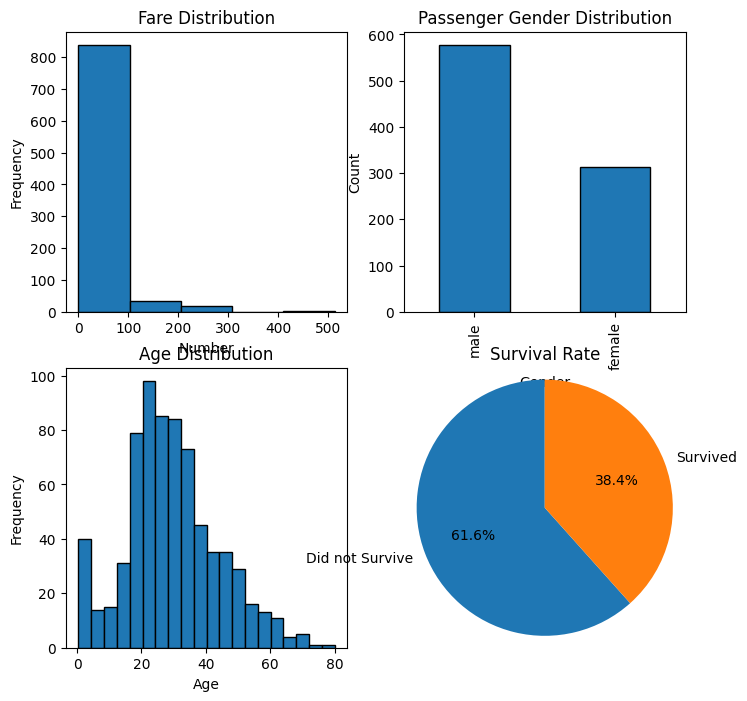

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.hist(train_data['Fare'], bins=5, edgecolor='k')
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Fare Distribution')

plt.subplot(2, 2, 2)
train_data['Sex'].value_counts().plot(kind='bar', edgecolor='k')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Passenger Gender Distribution')

plt.subplot(2, 2, 3)
plt.hist(train_data['Age'], bins=20, edgecolor='k')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')

plt.subplot(2, 2, 4)
plt.pie(train_data['Survived'].value_counts(), labels=['Did not Survive', 'Survived'], autopct='%1.1f%%', startangle=90)
plt.title('Survival Rate')
plt.axis('equal')

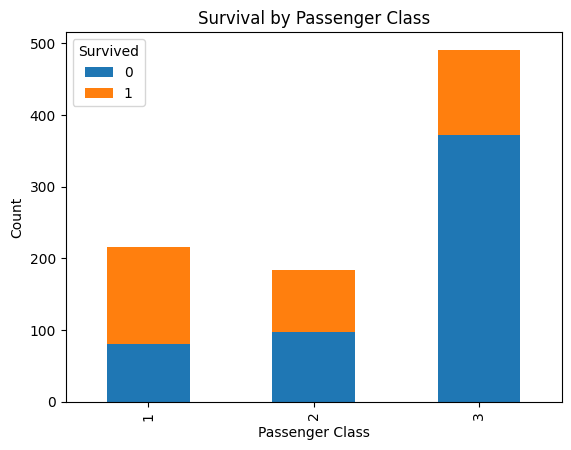

In [5]:
survival_by_class = train_data.groupby(['Pclass', 'Survived'])['PassengerId'].count().unstack()
survival_by_class.plot(kind='bar', stacked=True)
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.title('Survival by Passenger Class')
plt.show()

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

stripped_data = train_data.drop(['Name', 'Ticket', 'Fare', 'Cabin'], axis=1)

# columns to one-hot encode
categorical_columns = ['Sex', 'SibSp', 'Parch', 'Embarked']

# Create a ColumnTransformer with OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)],
    remainder='passthrough'  # Keep non-categorical columns
)

# Fit and transform the data using the ColumnTransformer
encoded_data = preprocessor.fit_transform(stripped_data)

# Convert the encoded data back to a Pandas DataFrame with column names
encoded_df = pd.DataFrame(encoded_data, columns=preprocessor.get_feature_names_out(input_features=stripped_data.columns))

corr_matrix = encoded_df.corr()
corr_matrix["remainder__Survived"].sort_values(ascending=False)


remainder__Survived       1.000000
cat__Sex_female           0.543351
cat__SibSp_1              0.173076
cat__Embarked_C           0.168240
cat__Parch_1              0.134174
cat__Parch_2              0.075020
cat__Embarked_nan         0.060095
cat__Parch_3              0.033391
cat__SibSp_2              0.029796
cat__Embarked_Q           0.003650
remainder__PassengerId   -0.005007
cat__Parch_6             -0.026456
cat__Parch_5             -0.028398
cat__SibSp_3             -0.037215
cat__Parch_4             -0.053002
cat__SibSp_5             -0.059292
cat__SibSp_4             -0.064123
cat__SibSp_8             -0.070234
remainder__Age           -0.077221
cat__SibSp_0             -0.115867
cat__Parch_0             -0.147408
cat__Embarked_S          -0.155660
remainder__Pclass        -0.338481
cat__Sex_male            -0.543351
Name: remainder__Survived, dtype: float64

## First takeaways

- strong positive correlation of female sex and survival
- strong negative correlation between male sex and survival
- siblings were more likely to survive
- negative correlation between class and survival -> the lower class was less likely to survive